In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
import scipy.interpolate
import numpy as np
import scipy.stats as sts

n0 = 0.16 #MeV/fm^3
pi = np.pi
MeV_to_km = 1.323e-6

In [8]:
EOS_small = pd.read_table('../data/EOSCEFTVE1.dat', header=None).to_numpy()

We are going to extend this table through the speed of sound. We are using the speed of sound because of it's definition:

$$ c_s^2 = \frac{\partial p(\epsilon)}{\partial \epsilon} $$

The mechanics will work like Ingo et. al. where we step the baryon density, $n$, by a small $\Delta n$,

$$ n_{i+1} = n_i + \Delta n $$

where $i$ is the index of our data array. Then we use the speed of sound, $c_s$, and a thermodynamic identity to get the energy density and pressure.

$$
\begin{align}
    \epsilon_{i+1} &= \epsilon_i + \Delta n \left( \frac{\epsilon_i + p_i}{n_i} \right)\\
    p_{i+1} &= p_i + c_s^2(n_i) \Delta n \left( \frac{\epsilon_i + p_i}{n_i} \right)
\end{align}
$$
    
We will be defining our speed of sound curve in this notebook by specifying its value at a number of points and just connecting the two with linear segments. The speed of sound (in units where c=1) must be between 0 and 1 to keep causality.

To begin, let's get the speed of sound in the range we already have (n < 2n0).

In [9]:
n = EOS_small[:,0] 
p = EOS_small[:,1] 
e = EOS_small[:,2] 

# derivative of pressure wrt energy
dp_de = scipy.interpolate.CubicSpline(p, e).derivative(nu=1)

#definition of speed of sound
c_s_2n0 = np.sqrt(1/dp_de(p[-1]))
print(n)

[4.00000001e-15 4.73000011e-15 4.75999990e-15 ... 3.19600000e-01
 3.19800000e-01 3.20000000e-01]


In [30]:
def sample_cs(num_points, max_n, n_start, cs_start):
    
    # sample random points in density
    epsilon = 1e-17
    loc_n = n_start + epsilon #to guarentee we don't randomly pull n_start
    scale_n = max_n - n_start - epsilon
    sample_n = sts.uniform.rvs(loc=loc_n, scale=scale_n, size=num_points-1)
    # order these points
    n_sort = np.sort(sample_n)
    
    # sample speeds of sound
    sample_cs = sts.uniform.rvs(size=num_points)
    
    # construct the arrays
    n_0 = n_start*np.ones(1)
    n = np.append(n_0, n_sort)
    ns = np.append(n, max_n)
    
    c_0 = cs_start*np.ones(1)
    cs = np.append(c_0, sample_cs)
    
    return ns, cs

[0.1335229  0.89066054 0.86306079 0.45785402 0.22816145 0.06009452
 0.14601021 0.59383981 0.2152085 ]


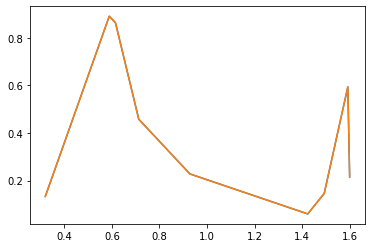

In [39]:
num_points = 8
n_start = n[-1]
max_n = 10*n0

ns, cs = sample_cs(num_points, max_n, n_start, c_s_2n0)

cs_lin = scipy.interpolate.interp1d(ns, cs)
cs_cube = scipy.interpolate.CubicSpline(ns, cs)

print(cs**2)

plt.plot(ns, cs_lin(ns)**2)
plt.plot(ns, cs_cube(ns)**2)

In [45]:
def extend_EOS(n_step, cs_func):

    size = int((max_n-n_start)/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = n_start
    EOS_ex[0,1] = p[-1]
    EOS_ex[0,2] = e[-1]

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        if cs_func(EOS_ex[k,0])**2 > 1:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        else:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*(cs_func(EOS_ex[k,0])**2)*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

def stitch_EOS(small_EOS, EOS_ex):
    
    # get relevant sizes
    size_smol = small_EOS.shape[0] -1 # -1 becuase we don't want last duplicated entry
    size_ex = EOS_ex.shape[0]
    
    # initialize array
    tot_EOS = np.zeros((size_smol+size_ex, small_EOS.shape[1]))
    
    tot_EOS[:size_smol,:] = small_EOS[:size_smol,:]
    tot_EOS[size_smol:,0] = EOS_ex[:,0]
    tot_EOS[size_smol:,1] = EOS_ex[:,1]
    tot_EOS[size_smol:,2] = EOS_ex[:,2]
    
    return tot_EOS

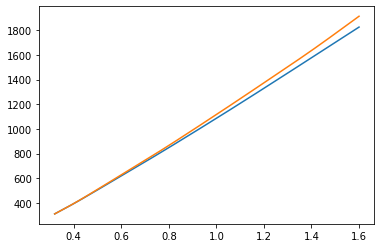

In [46]:
EOS_lin_ex = extend_EOS(1e-4, cs2_lin)
tot_EOS_lin = stitch_EOS(EOS_small, EOS_lin_ex)

np.savetxt('../data/EOS_test_linear.dat', tot_EOS_lin)

EOS_cube_ex = extend_EOS(1e-4, cs2_cube)
tot_EOS_cube = stitch_EOS(EOS_small, EOS_cube_ex)

np.savetxt('../data/EOS_test_cubic.dat', tot_EOS_cube)

plt.plot(EOS_lin_ex[:,0], EOS_lin_ex[:,2], '-')
plt.plot(EOS_cube_ex[:,0], EOS_cube_ex[:,2], '-')

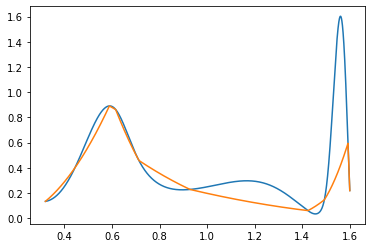

In [42]:
plt.plot(EOS_cube_ex[:,0], cs_cube(EOS_cube_ex[:,0])**2)
plt.plot(EOS_lin_ex[:,0], cs_lin(EOS_lin_ex[:,0])**2)

In [47]:
import real_TOVsolver

max_pressure = 350 #MeV/fm3

MRL_lin = real_TOVsolver.solve(tot_EOS_lin, max_pressure)
np.savetxt('../data/MRL_lin.dat', MRL_lin)

MRL_cube = real_TOVsolver.solve(tot_EOS_cube, max_pressure)
np.savetxt('../data/MRL_cube.dat', MRL_cube)

C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


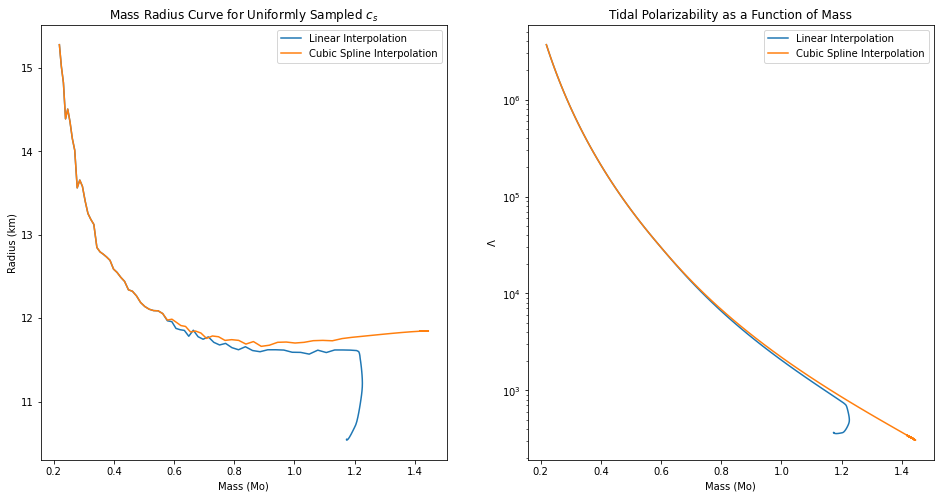

In [48]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(MRL_lin[:,0], MRL_lin[:,1], label='Linear Interpolation')
ax[0].plot(MRL_cube[:,0], MRL_cube[:,1], label='Cubic Spline Interpolation')
ax[0].set_xlabel('Mass (Mo)')
ax[0].set_ylabel('Radius (km)')
ax[0].set_title('Mass Radius Curve for Uniformly Sampled $c_s$')
ax[0].legend()

ax[1].plot(MRL_lin[:,0], MRL_lin[:,2], label='Linear Interpolation')
ax[1].plot(MRL_cube[:,0], MRL_cube[:,2], label='Cubic Spline Interpolation')
ax[1].set_xlabel('Mass (Mo)')
ax[1].set_ylabel('$\Lambda$')
ax[1].set_yscale('log')
ax[1].set_title('Tidal Polarizability as a Function of Mass')
ax[1].legend()

In [ ]:
import test_TOVsolver

MRL_test1 = test_TOVsolver.solve(tot_EOS, max_pressure)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(MRL_test[:,0], MRL_test[:,1])
ax[0].plot(MRL_test1[:,0], MRL_test1[:,1])
ax[0].set_xlabel('Mass (Mo)')
ax[0].set_ylabel('Radius (km)')
ax[0].set_title('Mass Radius Curve for Uniformly Sampled $c_s$')

ax[1].plot(MRL_test[:,0], MRL_test[:,2])
ax[1].plot(MRL_test1[:,0], MRL_test1[:,2])
ax[1].set_xlabel('Mass (Mo)')
ax[1].set_ylabel('$\Lambda$')
ax[1].set_yscale('log')
ax[1].set_title('Tidal Polarizability as a Function of Mass')